In [368]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

In [369]:
computer = pd.read_csv('computer_subcategory_classification.csv')
computer.head()

,website_url,cleaned_website_text,Category
0,http://www.kasrl.org/jaffe.html,japanese female facial expression jaffe datase...,Computers and Technology
1,https://www.gmdhshell.com/,best predictive analytic software free academi...,Computers and Technology
2,http://en.wikipedia.org/wiki/Neural_network,neural network wikipedia neural network conten...,Computers and Technology
3,http://cadingandcoding.blogspot.com/,cading coding cading coding tuesday march auto...,Computers and Technology
4,http://www.panzercad.com/,welcome bluehost rate web host provider free c...,Computers and Technology


In [370]:
computer["Category"].value_counts()

Cyber Security              122
Computers and Technology     93
Cryptocurrency               80
Name: Category, dtype: int64

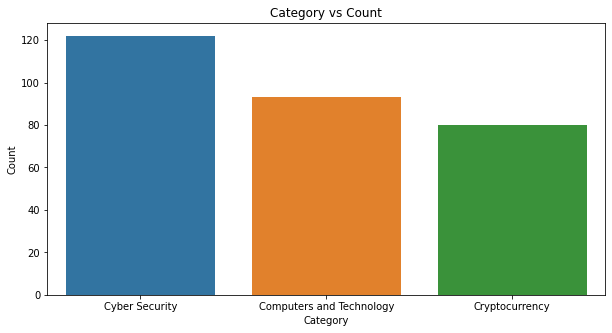

In [371]:
#Putting values into graph
plt.figure(figsize=(10,5))
plt.title("Category vs Count")
computer_category_count = pd.DataFrame(computer["Category"].value_counts())
sns.barplot(x=computer_category_count.index, y=computer_category_count["Category"])
plt.ylabel("Count")
plt.xlabel("Category")
plt.show()

### Cleaning the text

In [362]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

stop_words = stopwords.words('english')
import string

lem = WordNetLemmatizer()

def pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return 'a'
    elif nltk_tag.startswith('V'):
        return 'v'
    elif nltk_tag.startswith('R'):
        return 'r'
    else:
        return 'n'
    
#Define function to lemmatize each word with its POS tag
def lemmatize_words(text):
    pos_tagged_text = nltk.pos_tag(text)
    pos_tagged_text = [(word, pos_tagger(pos_tag)) for word, pos_tag in pos_tagged_text]
    return [lem.lemmatize(word, pos_tag) for word, pos_tag in pos_tagged_text]

In [363]:
import translators as ts

computer["cleaned_website_text"] = computer["cleaned_website_text"].apply(lambda x: x.lower())
computer["cleaned_website_text"] = computer["cleaned_website_text"].apply(lambda x: re.sub(r'[^\w\s]','',x))
computer["cleaned_website_text"] = computer["cleaned_website_text"].apply(lambda x: re.sub(r'\d+','',x))
computer["cleaned_website_text"] = computer["cleaned_website_text"].apply(lambda x: re.sub(r' +',' ',x))
computer["cleaned_website_text"] = computer["cleaned_website_text"].apply(lambda x: word_tokenize(x))
computer["cleaned_website_text"] = computer["cleaned_website_text"].apply(lambda x: [word for word in x if word not in stop_words])
computer["cleaned_website_text"] = computer["cleaned_website_text"].apply(lambda x: lemmatize_words(x))
computer["cleaned_website_text"] = computer["cleaned_website_text"].apply(lambda x: ' '.join(x))

### Feature Extraction: Label Encoding

In [364]:
le = LabelEncoder()
computer["Category"] = le.fit_transform(computer["Category"])
computer.tail()

,website_url,cleaned_website_text,Category
259,https://www.axonius.com,axonius cybersecurity asset management saas ma...,2
260,https://www.secureworks.com,secureworks cybersecurity leader proven threat...,2
261,https://www.trustwave.com,lead manage detection response trustwavetrustw...,2
262,https://www.arbornetworks.com,ddos mitigation software tool arbor ddos platf...,2
263,http://www.enterthegrid.com/,primeurmagazine primeur weekly exascale superc...,0


In [366]:
#splitting dataset
X_train,X_test,y_train,y_test = train_test_split(computer["cleaned_website_text"], computer["Category"], test_size=0.2, random_state=42)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((211,), (53,), (211,), (53,))

### Training Model Pipeline

In [367]:
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming you have your training data (X_train) and corresponding labels (y_train)

# Define the models and their respective hyperparameters to try during grid search
models = {
    'MNB': {
        'model': MultinomialNB(),
        'params': {
            'mnb__alpha': [0.1, 0.5, 1.0, 1.5, 2.0]
        }
    },
    'SVM': {
        'model': SVC(),
        'params': {
            'svm__C': [1, 10],
            'svm__kernel': ['linear', 'rbf']
        }
    },
}

# Perform grid search and cross-validation for each model
for model_name, model_data in models.items():
    print("Evaluating:", model_name)
    
    # Create a pipeline with a TF-IDF vectorizer and the current model
    pipeline = Pipeline([
        ("tfidf", TfidfVectorizer(analyzer='word',smooth_idf=True, stop_words='english',max_features=5000)),
        ("feature_selection", SelectKBest(score_func=chi2)),
        (model_name.lower(), model_data['model'])
    ])
    
    # Define the hyperparameters for the current model
    parameters = {
        'tfidf__ngram_range': [(1,1), (1,2)],
        'feature_selection__k':[1000, 2000, 3000, 4000, 5000],
        **model_data['params']
    }
    
    # Perform grid search with 5-fold cross-validation
    grid_search = GridSearchCV(pipeline, parameters, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    
    # Get the best model and its corresponding hyperparameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    # Make predictions on the test set
    y_pred = best_model.predict(X_test)
    
    # Calculate and print evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print("Best parameters:", best_params)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 score:", f1)
    print("----------------------------------")

Evaluating: MNB


c:\Users\User01\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
500 fits failed out of a total of 1250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\User01\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\User01\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\pipeline.py", line 390, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "c:\Users\User01\AppData\Local\Programs\Python\Python39\lib\site-packages\s

Best parameters: {'feature_selection__k': 4000, 'mnb__alpha': 1.5, 'tfidf__max_features': 4000, 'tfidf__ngram_range': (1, 2)}
Accuracy: 0.8490566037735849
Precision: 0.8566037735849056
Recall: 0.8490566037735849
F1 score: 0.8507778881165178
----------------------------------
Evaluating: SVM


c:\Users\User01\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
400 fits failed out of a total of 1000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\User01\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\User01\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\pipeline.py", line 390, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "c:\Users\User01\AppData\Local\Programs\Python\Python39\lib\site-packages\s

Best parameters: {'feature_selection__k': 1000, 'svm__C': 1, 'svm__kernel': 'linear', 'tfidf__max_features': 1000, 'tfidf__ngram_range': (1, 1)}
Accuracy: 0.9056603773584906
Precision: 0.9110512129380054
Recall: 0.9056603773584906
F1 score: 0.9062893081761005
----------------------------------


In [262]:
#TF-IDF
features = 2000
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(analyzer='word',smooth_idf=True, stop_words='english',max_features=features,ngram_range=(1,2))
tfidf.fit(computer["cleaned_website_text"])
X_train_tfidf = tfidf.transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [263]:
K = 2000
chi2_selector = SelectKBest(chi2, k=K)
X_train_kbest = chi2_selector.fit_transform(X_train_tfidf, y_train)
X_test_kbest = chi2_selector.transform(X_test_tfidf)

In [264]:
model = MultinomialNB(alpha=1.5)
model.fit(X_train_kbest, y_train)

MultinomialNB(alpha=1.5)

In [265]:
import sklearn.metrics as sm

y_pred = model.predict(X_test_kbest)

print(f'The accuracy of train model is {sm.accuracy_score(y_train,model.predict(X_train_kbest))}')
print(f'The accuracy of test model is {sm.accuracy_score(y_test,y_pred)}')

The accuracy of train model is 0.990521327014218
The accuracy of test model is 0.9811320754716981


In [266]:
from bs4 import BeautifulSoup
import bs4 as bs4
from urllib.parse import urlparse
import requests
import pandas as pd
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import os


class ScrapTool:   
    def visit_url(self,website_url):
        '''
        Visit URL. Download the Content. Initialize the beautifulsoup object. Call parsing methods. Return Series object.
        '''
        #Set up Selenium webdriver
        PATH = 'C:/Users/User01/Downloads/chromedriver_win32/chromedriver.exe'

        # Set the Chrome webdriver options
        chrome_options = Options()
        chrome_options.add_argument("--headless")
        # Initialize the Chrome webdriver and pass the Chrome options
        service = Service(PATH)
        driver = webdriver.Chrome(service = service, options = chrome_options)

        #Load website
        driver.get(website_url)
        
        # Check if the cookie consent button is present
        cookie_button = None
        try:
            cookie_button = WebDriverWait(driver, 15).until(EC.element_to_be_clickable((By.CSS_SELECTOR, "cookie-consent-button")))
        except:
            pass

        # Handle cookies if the button is present
        if cookie_button:
            cookie_button.click()

        # Extract HTML content
        html_content = driver.page_source
        driver.quit()

        soup = BeautifulSoup(html_content,'lxml')
        result = {
            "website_url": website_url,
            "website_name": self.get_website_name(website_url),
            "website_text": self.get_html_title_tag(soup)+self.get_html_meta_tags(soup)+self.get_html_heading_tags(soup)+
                                    self.get_text_content(soup)
        }
        
        #Convert to Series object and return
        return pd.Series(result)
    
    def get_website_name(self,website_url):
        '''
        Example: returns "google" from "www.google.com"
        '''
        return "".join(urlparse(website_url).netloc.split(".")[-2])
    
    def get_html_title_tag(self,soup):
        '''Return the text content of <title> tag from a webpage'''
        return '. '.join(soup.title.contents)
    
    def get_html_meta_tags(self,soup):
        '''Returns the text content of <meta> tags related to keywords and description from a webpage'''
        tags = soup.find_all(lambda tag: (tag.name=="meta") & (tag.has_attr('name') & (tag.has_attr('content'))))
        content = [str(tag["content"]) for tag in tags if tag["name"] in ['keywords','description']]
        return ' '.join(content)
    
    def get_html_heading_tags(self,soup):
        '''returns the text content of heading tags. The assumption is that headings might contain relatively important text.'''
        tags = soup.find_all(["h1","h2","h3","h4","h5","h6"])
        content = [" ".join(tag.stripped_strings) for tag in tags]
        return ' '.join(content)
    
    def get_text_content(self,soup):
        '''returns the text content of the whole page with some exception to tags. See tags_to_ignore.'''
        tags_to_ignore = ['style', 'script', 'head', 'title', 'meta', '[document]',"h1","h2","h3","h4","h5","h6","noscript"]
        tags = soup.find_all(text=True)
        result = []
        for tag in tags:
            stripped_tag = tag.strip()
            if tag.parent.name not in tags_to_ignore\
                and isinstance(tag, bs4.element.Comment)==False\
                and not stripped_tag.isnumeric()\
                and len(stripped_tag)>0:
                result.append(stripped_tag)
        return ' '.join(result)

In [267]:
def cleaning(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]','',text)
    text = re.sub(r'\d+','',text)
    text = word_tokenize(text)
    text = [word for word in text if word not in stop_words]
    text = lemmatize_words(text)
    text = ' '.join(text)
    vector = tfidf.transform([text])
    vector = chi2_selector.transform(vector)
    vector = vector.toarray()
    
    return vector

def website_prediction(website,model):
    scrapTool = ScrapTool()
    try:
        web = dict(scrapTool.visit_url(website))
        text = cleaning(web['website_text'])
        prediction = model.predict(text)
        print(f'The website is under the category of {le.inverse_transform(prediction)[0]}')
    except Exception as e:
        print(e)
        print("Connection Timeout")

In [268]:
import pickle

filename = 'CompSubCat.sav'
pickle.dump(model, open(filename, 'wb'))

#loading the model
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test_kbest, y_test)
print(result)

0.9811320754716981


              precision    recall  f1-score   support

           0       1.00      0.94      0.97        18
           1       1.00      1.00      1.00        15
           2       0.95      1.00      0.98        20

    accuracy                           0.98        53
   macro avg       0.98      0.98      0.98        53
weighted avg       0.98      0.98      0.98        53



<AxesSubplot:>

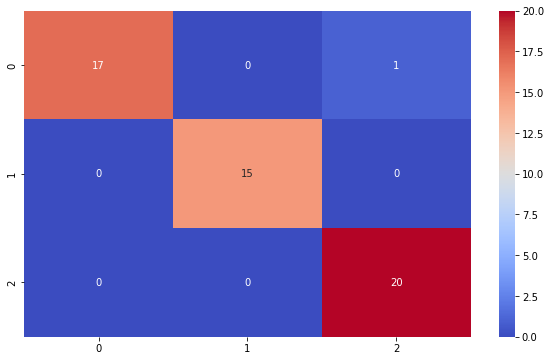

In [269]:
plt.figure(figsize=(10,6))
predictions = model.predict(X_test_kbest)
print(classification_report(predictions,y_test))
sns.heatmap(confusion_matrix(predictions,y_test),cmap='coolwarm',annot=True)

In [270]:
pd.set_option('display.max_rows', None)
predictions = model.predict(X_test_kbest)
results = pd.DataFrame({'Cleaned Text':X_test,'Actual':y_test,'Predicted':predictions})
results[results['Actual']!=results['Predicted']]

,Cleaned Text,Actual,Predicted
233,sucuri website firewall access deniedaccess de...,2,0


In [271]:
computer.iloc[233]

website_url                                    https://www.exploit-db.com
cleaned_website_text    sucuri website firewall access deniedaccess de...
Category                                                                2
Name: 233, dtype: object

In [272]:
website_prediction('https://www.acer.com/ac/en/US/content/home',loaded_model)

The website is under the category of Cryptocurrency


In [273]:
website_prediction("https://invezz.com/news/2023/06/01/ripple-labs-releases-1-billion-xrp-coins-from-escrow/",loaded_model)

The website is under the category of Cryptocurrency
